# ENPE 622 Term Project
## Find Pressure Traverse in a Wellbore Tubing using the Kartoatmodjo and Schmidt oil viscosity & Beggs and Brill Two-phase Model

### Summary

The following report provides a program to calculate pressure traverse (pressure gradient) in the production tubing under a multiphase flow condition. The fluids present in the tubing are confined to Oil and Gas only and the respective fluid models are used to determine their properties at the average pressure and temperature across all the segments of the pipe. The pipe is divided into 50 segments of 200ft, leading to a total vertical depth of 10,000ft. The well produces an oil flow rate of 600 STB/Day at the surface with a GOR of 1500 SCF/STB. Therefore, to incorporate gas into the pressure modelling, Beggs and Brill's two phase flow correlation is utlized to identify the relative oil and gas properties at the in-situ wellbore conditions, and hence identify the total pressure drop at any given depth. 



# PART 1: Initialization and Function/Class definition
##### Importing the packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Defining the functions that would calculate the fluid properties at average pressure and temperature. 
The starting point is using the specific gravities at the surface conditions as input parameters in the correlations that
calculate the the fluid properties at desired condition of the pipeline segment.


### Nomenclature

* TPC: Critical Pressure $(psi)$
* PPC: Critical Temperature $^OF$
* Ppr: Pseudo-Reduced Pressure $Ppr$
* Tpr: Pseudo-Reduced Temperature $Tpr$
* ZFact: Gas Compressibilty Factor $Z$
* MW: Gas Molecular weight $Mw$
* GVISC: Gas viscosity $\mu_g$
* OVISC: Oil viscosity $\mu_o$
* Rs: solution gas-oil ratio $R_s$
* GFVF: Gas formation Volume Factor $B_g$
* Bo: Oil formation Volume Factor $B_o$
* OilDensity: Oil density $\rho_o$
* GasDensity (rho_gas): Gas density $\rho_g$
* GOIT: interfacial tension to oil-gas $\sigma_o$
* usl: superficial liquid velovity $U_{sl}$
* usg: superficial gas velocity $U_{sg}$
* yl: no-slip liquid holdup $y_l$
* ftp: Two-phase friction factor $f_{tp}$
* fn: fanning friction factor $fn$
* NRE: Reynold's Number $N_{RE}$
* qg: In-situ Gas flow rate $Q_g$
* qo: In-situ Oil flow rate $Q_o$
* Press = pres_ave: Average pressure in the tubing segment $P$
* Temp = temp_ave: Average temperature in the tubing segment $T$
* dp: Total pressure gradient in the tubing segment $\Delta P$
* P1: Updtream pressure of the tubing segment $P1$

### Input Parameters at Standard Conditions

In [2]:
D = 1.38  #in
e_D = 0.001/12  #ft 
L = 10000  #ft
Press = 500  #psi
qo = 600  #STB/D
Temp  = 133  #F
API = 35  #API
gamma_G = 0.861  
GOR = 1500  #SCF/STB
n = 50
dl = 10000/50  #ft

## Gas Properties
#### Note 1: The correlations for TPC & PPC are valid for 0.57 < 𝛾𝛾𝑔𝑔 < 1.68, with there is no H2S in the gas, and the mole fractions of CO2 and N2 are less than 12% and 3%, respectively.

#### Note 2: Zfactor is calculated using Brill and Beggs correlation, where
* $Tpr = \dfrac{T}{T_{PC}}$ & $Ppr = \dfrac{P}{P_{PC}}$
* PPC is in psia, and Tpc is in Rankine

#### Note 3: Gas Molecular Weight, Density, and Formation Volume Factor
* $M_w = 28.964\gamma_g$
* $\rho_g = 2.6988\dfrac{P\gamma_g}{ZT}$
* $B_g = 0.028269\dfrac{ZT}{P}$
* where T: temperature, $^oR (Rankine)$

#### Note 4: Gas Viscoisty: Lee at all Correlation
* $\mu_g = 10^{-4} K \exp[X(\dfrac{\rho_g}{62.37})]^Y$
* $K = \dfrac{9.379+0.01607M_{wg}T^{1.5}}{209.2+19.26M_{wg}+T}$
* $X = 3.448 + \dfrac{986.4}{T} + 0.01009M_w$
* $Y = 2.447 - 0.2224X$
* where $\mu_g = cp$ </br>$T: temperature, ^oR (Rankine)$

In [3]:
class GasProperties:
    
    """ A class used to calculate Gas Properties using Temperature, Pressure and 
        Gas specific gravity
        
        ...
        
        Parameters
        ------------
        
        Temp: integer
            The temperature of gas in Fahrenheit (F)
            
        Press: integer
            The pressure of gas in psi
            
        gamma_G: float
            The specific gravity of gas
            
        
        
        Variables
        ------------
        tpr: float
            Pseudo-reduced Temperature
            
        ppr: float
            Pseudo-reduced Pressure
            
        Mw: float
            Gas Molecular weight
            
            
        
        Methods
        -----------
        
        TPC: Pseudo-critical Temperature (F)
            calculates the pseudo-critical temperature using sutton's (1985) correlation
            
        PPC: Pseudo-critical Pressure (psi)
            calculates the pseudo-critical pressure using sutton's (1985) correlation
            
        ZFact: Gas compressibilty factor 
            calualtes the gas compressibilty factor using beggs & brill (1987) correlation
            
        GFVF: Gas formation volume factor (ft3/SCF)
            calulates the gas formation volume factor
            
        GVISC: Gas viscosity (cP)
            caculates the gas viscosity
        
        GasDensity: Gas density (lbm/ft3)
            calulates the gas density
=========================================================================================            
            """
    
    
    def __init__(self, Temp, Press, gamma_G):
        self.gamma_G = gamma_G
        self.Press = Press
        self.Temp = Temp
        
    def TPC(self):
        return 169.2 + 349.5*self.gamma_G - 74*(self.gamma_G**2)
    
    def PPC(self):
        return 756.8 - 131*self.gamma_G - 3.6*(self.gamma_G**2)
    
    def ZFact(self):
        tpr = (self.Temp+459.69) / self.TPC()
        ppr = self.Press / self.PPC()
        D = 10**(0.3106 - 0.49 * tpr + 0.1824 * (tpr**2))
        C = 0.132 - (0.32 * np.log10(tpr))
        B = (0.62 - (0.23*tpr))*ppr + ((0.066/(tpr - 0.86)) - 0.037) * (ppr**2) + (0.32/(10**(9*(tpr-1))))*ppr**6
        A = 1.39*((tpr - 0.92)**0.5) - 0.36*tpr - 0.101
        Z = A + (1 - A)*np.exp(-B) + C*(ppr**D)
        return Z
    
    def GFVF(self):
        Temp = self.Temp + 459.69
        return 0.028269 * ((self.ZFact()*Temp) / self.Press)
    
    def GVISC(self):
        Temp = self.Temp + 459.69
        Mw = 28.964 * self.gamma_G
        Rho_g = 2.6988 * ((self.Press*self.gamma_G) / (self.ZFact()*Temp))
        K = ((9.379 + 0.01607*Mw) * (Temp**1.5)) / (209.2 + (19.26*Mw) + Temp)
        X = 3.448 + (986.4/Temp) + (0.01009*Mw)
        Y = 2.447 - 0.2224*X
        return 10**-4 * K * np.exp(X * (Rho_g / 62.37)**Y)
    
    def GasDensity(self):
        Temp = self.Temp + 459.69
        return 2.6988 * ((self.Press*self.gamma_G) / (self.ZFact()*Temp))

In [4]:
# Creating an instance "G" of the class using the intial well conditions
Temp = 133
Press = 500
gamma_G = 0.861

G = GasProperties(Temp, Press, gamma_G)

## Oil Properties

#### Note 1: Standing Correlation
* $R_s(P,T) = \gamma_g[(\dfrac{P}{18.2}+1.4)10^A]^{1.2048}$
* A = $0.0125API - 0.00091T$</br>where:
* $R_s$: Solution or dissolved gas $\dfrac{SCF}{STB}$
* $T = temperature, ^oF$
* $P = pressure, psia$


#### Note 2: Oil formation volume factor (Standing (1947 and Vasquez and Beggs (1997) Correlations)
* $B_o = 0.972 + 0.000147F^{1.175}$
* $F = R_s(\dfrac{\gamma_g}{\gamma_o})^{0.5} + 1.25T$</br>
* $T: temperature, ^oF$


#### Note 3: Oil Density
$\rho_o = \dfrac{350\gamma_o + 0.0764\gamma_gR_s}{5.615B_o}$</br>where
* $\gamma_o = \dfrac{141.5}{131.5+API}$


#### Note 4: Gas-Oil Interfacial Tension
* $\sigma_{o(100)} = 37.5 - 0.02571(API)$
* If $T > 100^oF,\sigma_o = (1.0 - 0.024P^{0.45})\sigma_{o(100)}$</br>where
* $T: temperature, ^oF$


#### Note 5: Oil viscosity (Kartoatmodjo and schmidt(1991))
* $\mu_{od} = c[log(API)]^d$
* $c = 16\times10^8T^{-2.8177}$
* $d = 5.7526 log(T) - 26.9718$
* $B = 10^{-0.00081R_s}$
* $A = 0.2001 + 0.8428[10^{-0.000845R_s}]$
* $F = A\mu_{od}^{(0.43+0.5165B)}$
* $\mu_o = -0.06821 + 0.9824F + 0.0004034F^2$

In [5]:
class OilProperties:
    
    """ A class used to calculate Oil Properties using Temperature, Pressure, 
        Gas specific gravity and API
        
        ...
        
        Parameters
        ------------
        
        Temp: integer
            The temperature of gas in Fahrenheit (F)
            
        Press: integer
            The pressure of gas in psi
            
        gamma_G: float
            The specific gravity of gas
            
        API:
            index of the density of a crude oil
            
            
        Variables
        -----------
        U_od: float
            Dead oil viscoisty
            
        
        Methods
        -----------
        
        Rs: Solution Gas-Oil Ratio (SCF/STB)
            calculates the Solution Gas-Oil Ratio using standing's (1947) correlation
            
        Bo: Oil formation volume factor (bbl/STB)
            calulates the gas formation volume factor using standing (1947), 
            vasquez and beggs (1977) correlation
            
        OilDensity: Oil Density (lbm/ft3)
            calculates the pseudo-critical pressure using sutton's (1985) correlation
            
        GOIT: Gas-Oil Interfacial Tension (dynes/cm)
            calculates the gas-oil interfacial tension
            
        OVISC: Oil Viscosity (cP)
            calculates the oil-viscosity using Kartoatmodjo and Schmidt (1991) dead oil
            and saturated oil viscosity correlation
            
===========================================================================================            
            """
    
    def __init__(self, Temp, Press, gamma_G, API):
        self.gamma_G = gamma_G
        self.Press = Press
        self.Temp = Temp
        self.API = API
        self.gamma_O = 141.5 / (131.5 + API)
    
    def Rs(self):
        A = 0.0125 * self.API - 0.00091*self.Temp
        return self.gamma_G * (((self.Press/18.2)+1.4) * (10**A))**1.2048
    
    def Bo(self):
        F = self.Rs() * ((self.gamma_G/self.gamma_O)**0.5) + 1.25*self.Temp
        return 0.972 + 0.000147*(F**1.175)
    
    def OilDensity(self):
        return ((350*self.gamma_O) + (0.0764 * self.gamma_G * self.Rs())) / (5.615 * self.Bo())
    
    def GOIT(self):
        o_100 = 37.5 - 0.2571*self.API
        return (1 - 0.024*(self.Press**0.45)) * o_100
    
    def OVISC(self):
        d = 5.7526 * np.log10(self.Temp) - 26.9718
        c = (16 * 10**8) * (self.Temp**(-2.8177))
        U_od = c*(np.log10(self.API))**d
        
        B = 10**(-0.00081*self.Rs())
        A = 0.2001 + 0.8428*(10**(-0.000845*self.Rs()))
        F = A * (U_od**(0.43 + 0.5165*B))
        return -0.06821 + 0.9824*F + (0.0004034*(F**2))

In [6]:
# Creating an instance "O" of the class using the intial well conditions
Temp = 133
Press = 500
gamma_G = 0.861
API = 35

O = OilProperties(Temp, Press, gamma_G, API)

# PART 2: In-Situ Properties

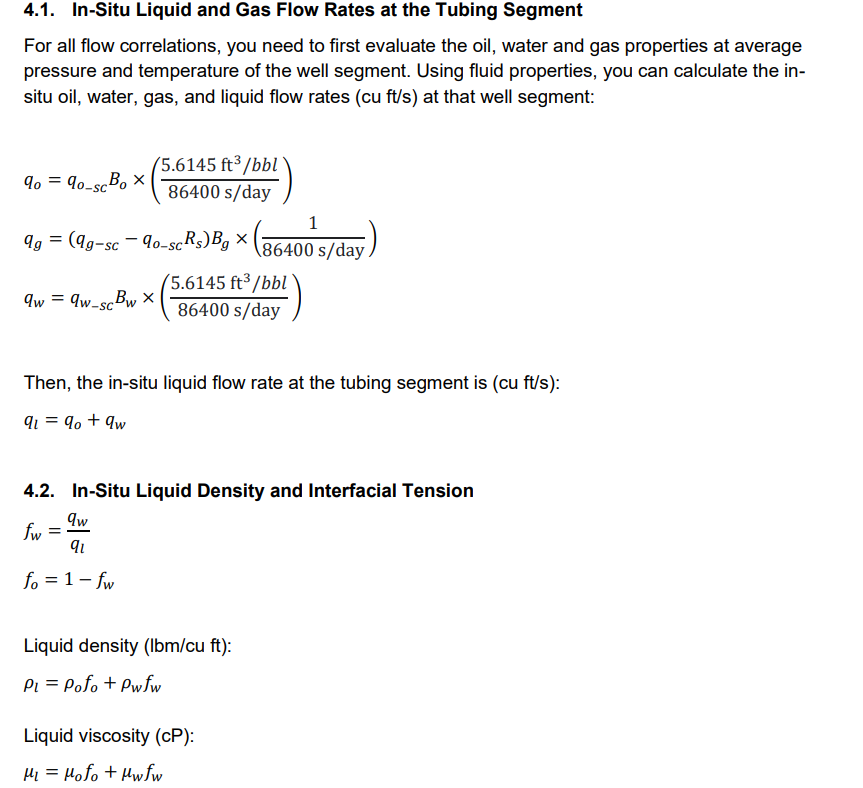

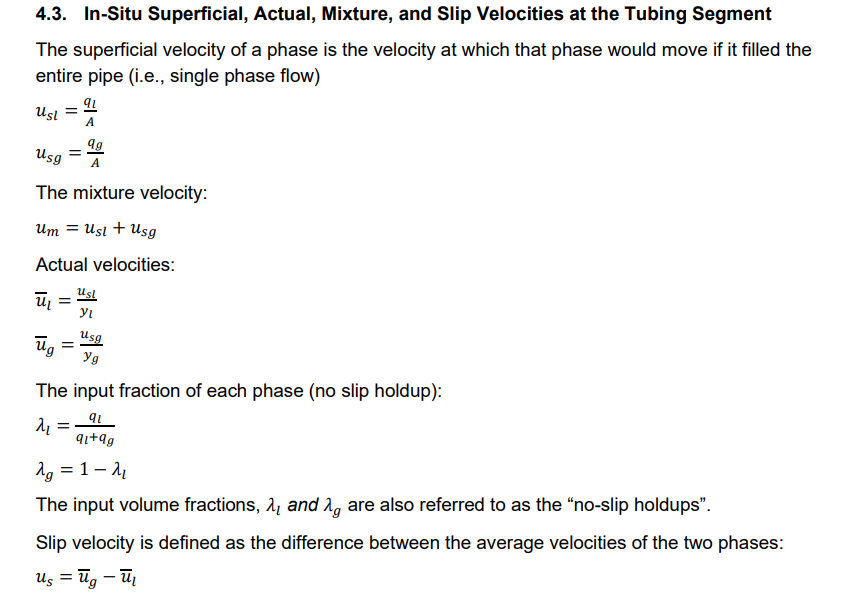

In [7]:
def InSituProperties(qo_sc, Bo, Rs, GFVF, Rho_O, uo, oo):
    
    """ A function that calculates the in-situ properties in a well section
    based on provided fluid properties
    ...
    
    Parameters
    -----------
    qo_sc: integer
        Liquid flowrate (STB/D)
    
    Bo: float
        Oil formation value (bbl/STB)
    
    Rs: float
        Solution Gas-Oil Ratio (SCF/STB)
    
    GFVF: float
        Gas formation volume factor (ft3/SCF)
    
    Rho_O: float
        Oil Density (lbm/ft3)
    
    oo: float
       Gas-Oil Interfacial Tension (dynes/cm) 
    
    
    Variables
    -----------
    GOR: integer 
        Gas-Oil Ratio (SCF/STB)
        
    Rho_l: float
        Liquid density (lbm/ft3)
    
    qo: float
        In-situ oil flow rate (ft3/s)
    
    qg_sc: float
        Gas flow rate at standard conditions (SCF/D)
    
    qw: 
        In-situ water flow rate (ft3/s)
    
    ql: float
        In-situ liquid flow rate (ft3/s)
    
    fw: float
        water fraction
    
    fo: float
        oil fraction
    
    ul: float
        liquid viscosity (cP)
    
    ol: float
        liquid gas interfacial tension (dynes/cm)
    
    D: float
        Tubing internal diamter (in)
    
    usg, usl: float
        superficial gas and liquid velocity (ft/s)
    
    um: float
        mixture velocity (ft/s)
    
    lambda_l, lambda_g: float
        no slip holdup
    
    
    returns
    -----------
    um, lambda_l, Rho_l, lambda_g, usg, usl, ol
    
   ========================================================================
   """
    
    GOR = 1500
    qg_sc = qo_sc*GOR
    qo = (qo_sc * Bo) * (5.615/86400)
    qg = ((qg_sc - (qo_sc*Rs))*GFVF) * (1/86400)
    qw = 0

    ql = qo + qw
    
    fw = qw / ql
    fo = 1 - fw

    # Liquid density
    Rho_l = (Rho_O*fo) + (62.4*fw)

    #Liquid viscosity
    ul = (uo*fo) + (0*fw)

    # Liquid-gas interfacial tension
    ol = (fo*oo) + (0)
    
    # Superficial velocity
    D = (1.38/12)
    usl = ql/((np.pi*(D**2))/4)
    usg = qg/ ((np.pi*(D**2))/4)

    # Mixture velocity
    um = usl + usg

    # Input fraction of each phase
    lambda_l = ql/(ql + qg)
    lambda_g = 1 - lambda_l
    
    return um, lambda_l, Rho_l, lambda_g, ul, usg, usl, ol

## PART 3: Beggs and Brill (1973) Two Phase model

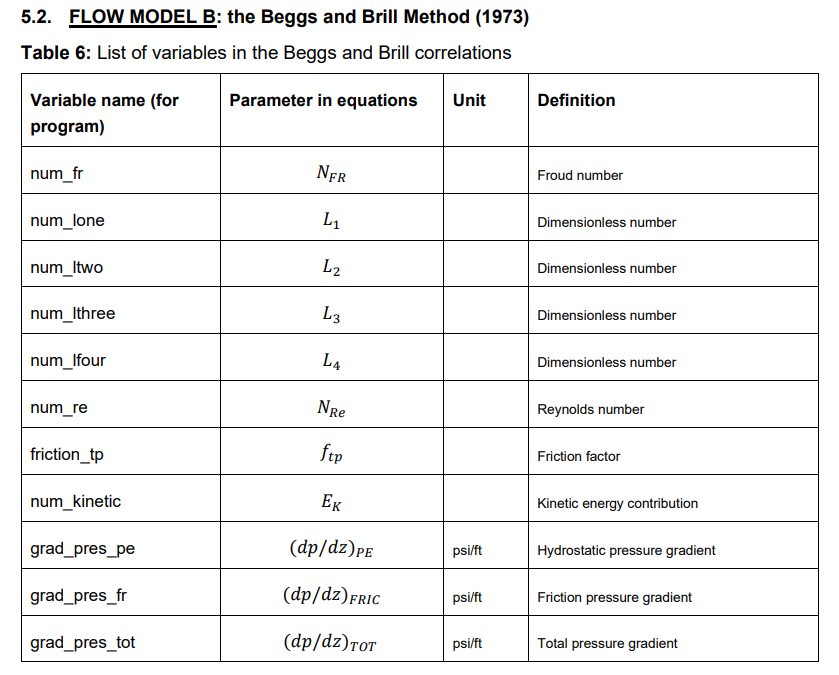

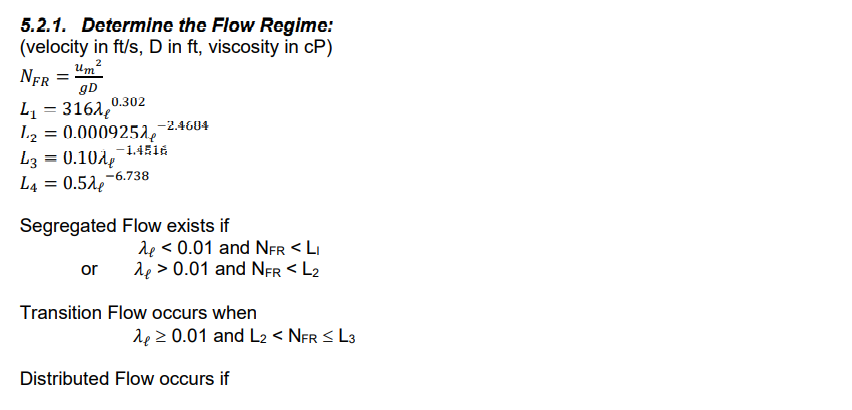

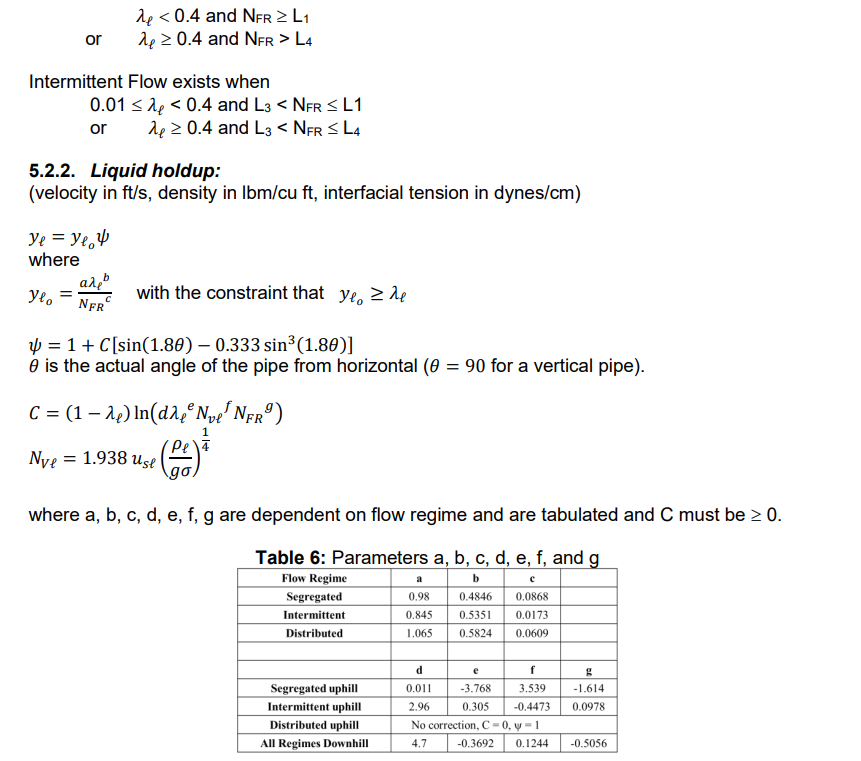

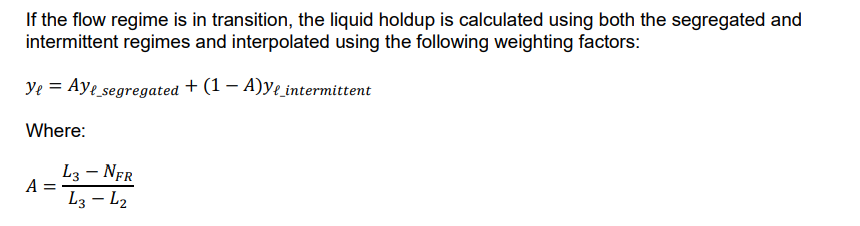

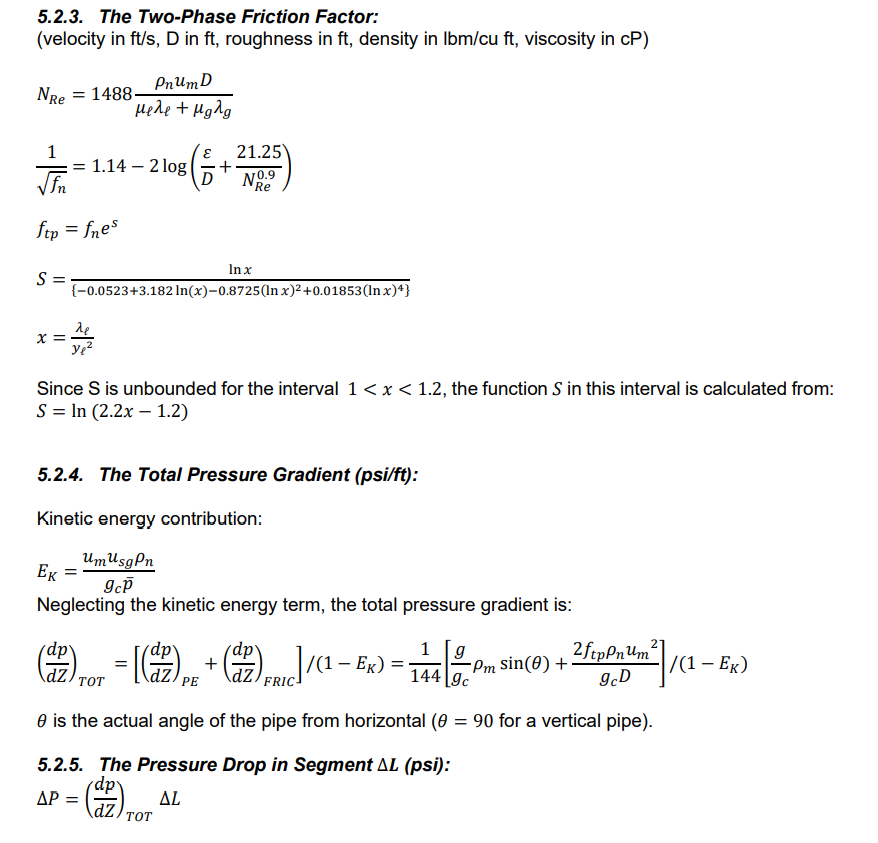

In [8]:
def BeggsAndBrill(um, lambda_l, Rho_l, usl, ol):

    """ Two-Phase Beggs and Brill Model
    ...
    
    Parameters
    -----------
    um: float
        mixture velocity (ft/s)
    
    lambda_l, lambda_g: float
        no slip holdup
        
    Rho_l: float
        Liquid density (lbm/ft3)
        
    usl: float
        superficial gas and liquid velocity (ft/s)
        
    ol: float
        liquid gas interfacial tension (dynes/cm)
        
    
    Variables
    ------------
    g: float
        acceleration of gravity (32.17ft/s)
    
    D: float
        Tubing internal diamter (in)
    
    NFR: float
        Fround number
    
    NVL: float
        Liquid velocity number
    
    yl: float
        Liquid holdup
    
    e_D: float
        pipe relative roughness
    
    Rho_g: float
        Gas density (lbm/ft3)
    
    ug: float
        Gas viscosity (cP)
    
    Rho_m: float
        Mixture density (lbm/ft3)
    
    Rho_n: float
        Average density (lbm/ft3)
    
    NRE: float
        Reynolds number
    
    fn, ftp: float
        fanning friction factor, friction factor
        
    
    returns
    ------------
    Rho_m, ftp, Rho_n, flow
    
    """
    g = 32.17
    D = (1.38/12)
    NFR = um**2/(g*D)
    L1 = 316*(lambda_l**0.302)
    L2 = 0.000925*(lambda_l**-2.4684)
    L3 = 0.10*(lambda_l**-1.4516)
    L4 = 0.5*(lambda_l**-6.738)


    if (lambda_l < 0.01 and NFR < L1) or (lambda_l > 0.01 and NFR < L2):
        flow = 'segregated flow'
        a, b, c, d, e, f, g = 0.98, 0.4846, 0.0868, 0.011, -3.768, 3.539, -1.614

    elif lambda_l >= 0.01 and (L2 < NFR <= L3):
        flow = 'transition flow'

    elif (lambda_l < 0.4 and NFR >= L1) or (lambda_l >= 0.4 and NFR > L4):
        flow = 'distributed flow'
        a, b, c = 1.065, 0.5824, 0.0609

    elif ((0.01 <= lambda_l < 0.4) and (L3 < NFR <= L1)) or (lambda_l >= 0.4 and (L3 < NFR <= L4)):
        flow = 'intermittent flow'
        a, b, c, d, e, f, g = 0.845, 0.5351, 0.0173, 2.96, 0.305, -0.4473, 0.0978

    else:
        flow = 'ERORR!!'

    if flow == 'segregated flow' or flow == 'intermittent flow':
        # Liquid Holdup
        ylo = (a*(lambda_l**b))/(NFR**c) # ylo >= lambda_l
        NVL = 1.938*usl*((Rho_l/ol)**0.25)
        C = (1 - lambda_l)*np.log(d*(lambda_l**e)*(NVL**f)*(NFR**g))
        Y = 1 + C*(np.sin(np.radians(1.8*90)) - 0.333*(np.sin(np.radians(1.8*90)))**3)
        yl = ylo*Y

    elif flow == 'distributed flow':
        ylo = (a*(lambda_l**b))/(NFR**c)
        C = 0
        Y = 1
        yl = ylo*Y

    
    e_D = (0.001/1.38)
    Rho_g = G.GasDensity()
    ug = G.GVISC()

    Rho_m = (Rho_l*lambda_l) + (Rho_g*lambda_g)
    Rho_n = (Rho_l*yl) + (Rho_g*(1-yl))

    NRE = 1488*((Rho_m*um*D)/((ul*lambda_l) + (ug*lambda_g)))
    x = lambda_l / (yl**2)
    S = np.log(x) / (-0.0523+3.182*np.log(x)-(0.8725*np.log(x)**2)+0.01853*(np.log(x)**4))
    #fn = 1/(1.14 - (2*np.log10(e_D + (21.25/(NRE**0.9)))))**2
    fn = 0.004
    ftp = fn*(np.exp(S))
    
    return Rho_m, ftp, Rho_n, flow

In [9]:
# calculating the initial fluid properties
Bo = O.Bo()
Rs = O.Rs()
Rho_o = O.OilDensity()
uo = O.OVISC()
oo = O.GOIT()
GFVF = G.GFVF()

# calculating the initial in-situ properties using the initial fluid properties
um, lambda_l, Rho_l, lambda_g, ul, usg, usl, ol = InSituProperties(600, Bo, Rs, GFVF, Rho_o, uo, oo)
Rho_m, ftp, Rho_n, flow = BeggsAndBrill(um, lambda_l, Rho_l, usl, ol)

Perhaps the most important consideration taken for the workflow is associated with the fanning frcition factor (fn), with the help of trial and error, Reynold's number and relative roughness of the pipe, the (fn) value was picked off from the chart below, and taken as a constant = 0.004. It was taken into account that fn is a function of Reynold's number which tends to change with the change in flow rate, however, the variation was observed to be not significant and therefore a constant value was selected. The primary reason for this was to eliminate the error that was introduced by the empirical equation provided for the (fn). 

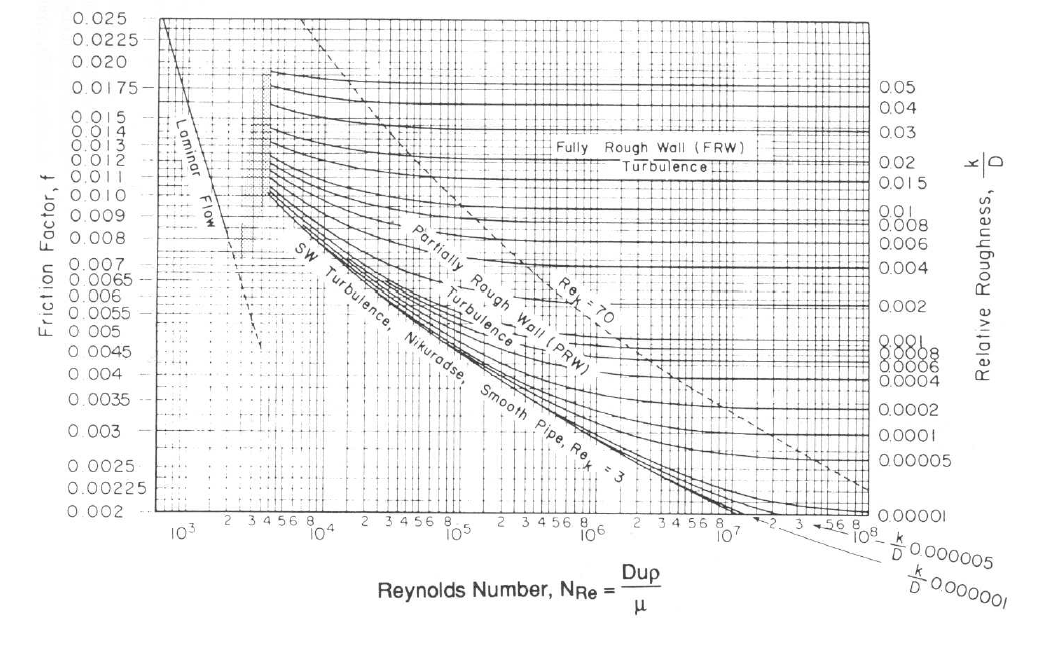

# PART 4: Iteration

In [10]:
T = np.linspace(133, 283, 51) # creating a list of temperatures from 133F to 283F
dl = 10000/50 # length of each well section
P1 = 500 # initial pressure (psi)

# calculating the initial pressure drop due to potential energy so we can initialize the iteration
dp = ((1/144)*(Rho_n*np.sin(np.radians(90))))*dl

# creating several lists for storing our calculated values
depth_list = [0, ]
error_list = [0,]
P_list = [500,]
flow_regime = ['distributed flow',]

"""  
Iteration explained
-----------------------
1. At the begining of EACH section of the well (50 segments in total), we define 
   our; condtion, API, gamma_G, D, temp1(t1), temp2(t2) and iteration counter 'i'.

2. We then calculate the average Temperature and Pressure at that section, and the 
   corresponding fluid and in-situ properties at the calculated Tave and Pave.
   
3. We calculate our Total pressure drop by using the calculated properties in step 2 to
   determine the summation of pressure drop due to friction and potential energy, multiplied 
   by the length of that section (dl).

4. We then check if our newly calculated total pressure drop is similar to our previous total
   pressure drop. If the error between both values is less than the defined tolerance, the condition for the
   while loop becomes false and we end the iteration for that section and prepare to move to the next section.
   However, if the error is still more than the tolerance we keep on iterating, using the newly calculated 
   total pressure drop to find our new Pave {Pave = P1 +(dp/2)}. 

5. Once the while loop condition has been satidifed and we find our total pressure drop for the current section, 
   we add it to the initial pressure to get P2, which in turn becomes the intial pressure (P1) of the next section.
   
6. We repeat steps 1 - 5, till we've gone through all sections of the well.

==================================================================================================================
"""
for a in range(50):
    print(f"Section {a+1} of the well")
    t1, t2 = T[a], T[a+1]
    condition = True
    tol = 0.00001
    API = 35
    gamma_G = 0.861
    D = (1.38/12)
    i = 0
    
    while condition:
        i += 1
        Tave = (t1 + t2)/2
        Pave = P1+(dp/2)
        
        # Creating an instance of the class 'OilProperties' using Tave, Pave, gamma_G and API
        O = OilProperties(Tave, Pave, gamma_G, API)
        
        # Returning the calculated oil properties using the parameters mentioned above
        Bo = O.Bo()
        Rs = O.Rs()
        Rho_O = O.OilDensity()
        uo = O.OVISC()
        oo = O.GOIT()
        
        # Creating an instance of the class 'GasProperties' using Tave, Pave, gamma_G and API
        G = GasProperties(Tave, Pave, gamma_G)
        
        # Returning the calculated gas property using the parameters mentioned above
        GFVF = G.GFVF()
        
        # Calling the InSituProperties & BeggsAndBrill functions and returning the required properties
        um, lambda_l, Rho_l, lambda_g, ul, usg, usl, ol = InSituProperties(600, Bo, Rs, GFVF, Rho_O, uo, oo)
        Rho_m, ftp, Rho_n, flow = BeggsAndBrill(um, lambda_l, Rho_l, usl, ol)
        
        
        # Calculating the total pressure drop in the current well section
        dp_TOT = (((1/144)*((Rho_n*np.sin(np.radians(90))) + ((2*ftp*Rho_m*(um**2))/(32.17*D)))))*dl
        
        # Calculating the error between new and old values of dp_TOT
        Ea = abs((dp_TOT - dp)/dp_TOT)
        
        # Condition for the while loop
        if Ea < tol:
            condition = False
        else:
            dp = dp_TOT

    
    P1 = P1 + dp_TOT
    P_list.append(round(P1,2))
    flow_regime.append(flow)
    error_list.append(Ea)
    depth_list.append((a+1)*200)
    print(f"After {i} iterations, P2 is {P1:,.2f}psia.\n")    

Section 1 of the well
After 5 iterations, P2 is 555.95psia.

Section 2 of the well
After 4 iterations, P2 is 609.65psia.

Section 3 of the well
After 3 iterations, P2 is 662.55psia.

Section 4 of the well
After 3 iterations, P2 is 714.27psia.

Section 5 of the well
After 3 iterations, P2 is 765.12psia.

Section 6 of the well
After 3 iterations, P2 is 815.32psia.

Section 7 of the well
After 3 iterations, P2 is 865.03psia.

Section 8 of the well
After 3 iterations, P2 is 914.38psia.

Section 9 of the well
After 3 iterations, P2 is 963.47psia.

Section 10 of the well
After 2 iterations, P2 is 1,012.38psia.

Section 11 of the well
After 2 iterations, P2 is 1,061.17psia.

Section 12 of the well
After 2 iterations, P2 is 1,109.89psia.

Section 13 of the well
After 2 iterations, P2 is 1,158.58psia.

Section 14 of the well
After 2 iterations, P2 is 1,207.28psia.

Section 15 of the well
After 2 iterations, P2 is 1,256.00psia.

Section 16 of the well
After 2 iterations, P2 is 1,304.77psia.

Sec

### Results

In [11]:
data_pres = {"pressure(psi)": P_list,"depth(ft)":depth_list,"temp(F)":T, "flow regime":flow_regime, "error":error_list}
data = pd.DataFrame(data_pres)
print(data)

    pressure(psi)  depth(ft)  temp(F)        flow regime         error
0          500.00          0    133.0   distributed flow  0.000000e+00
1          555.95        200    136.0   distributed flow  3.050241e-07
2          609.65        400    139.0   distributed flow  2.797379e-07
3          662.55        600    142.0  intermittent flow  2.911528e-06
4          714.27        800    145.0  intermittent flow  2.514458e-06
5          765.12       1000    148.0  intermittent flow  1.107021e-06
6          815.32       1200    151.0  intermittent flow  4.812708e-07
7          865.03       1400    154.0  intermittent flow  2.022472e-07
8          914.38       1600    157.0  intermittent flow  7.990301e-08
9          963.47       1800    160.0  intermittent flow  2.844963e-08
10        1012.38       2000    163.0  intermittent flow  5.603472e-06
11        1061.17       2200    166.0  intermittent flow  2.070338e-06
12        1109.89       2400    169.0  intermittent flow  4.397308e-07
13    

#### Provided Pressure Data - Excel Sheet

In [12]:
provided_pressure = sorted([3006.559, 2953.954, 2901.469, 2849.1040000000003, 2796.8590000000004, 2744.732, 2692.723, 2640.8340000000003, 2589.8720000000003, 2539.804, 2489.808, 2439.883, 2390.03, 2340.2470000000003, 2290.534, 2240.89, 2191.3160000000003, 2141.811, 2092.375, 2043.007, 1993.7060000000001, 1944.473, 1895.306, 1846.205, 1797.1670000000001, 1748.192, 1699.2779999999998, 1650.42, 1601.6170000000002, 1552.864, 1504.154, 1455.483, 1406.84, 1358.2179999999998, 1309.603, 1260.98, 1212.3319999999999, 1163.636, 1114.867, 1065.99, 1016.967, 967.7491, 918.2749, 868.4697, 818.2393, 767.4643, 715.9908, 663.6174, 610.5053, 556.2759, 499.9226])

## Pressure Traverse across Tubing

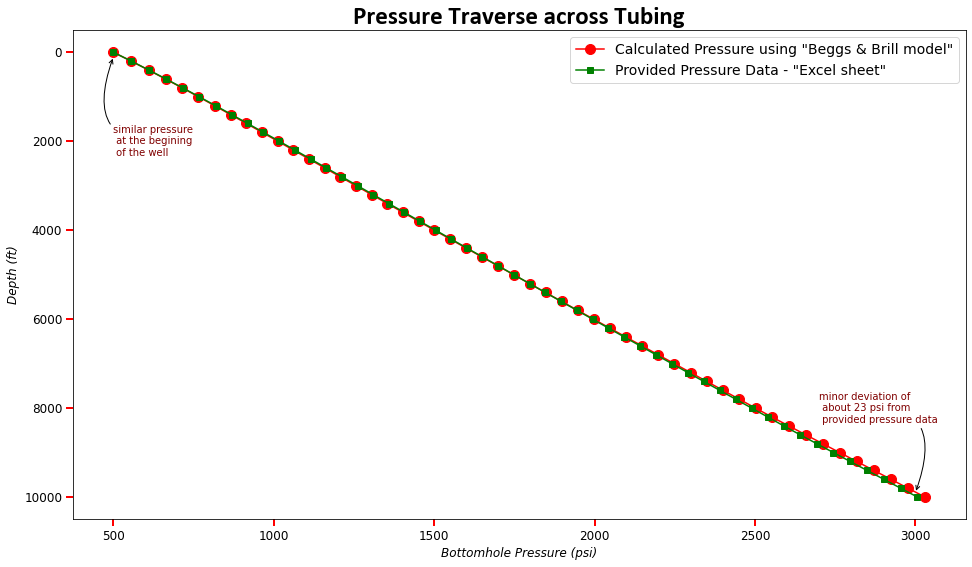

In [13]:
import warnings 
warnings.filterwarnings('ignore') # ignoring any deprecation warning python might raise


plt.figure(figsize=(16,9))
ax1=plt.subplot('111')
plt.plot(P_list, depth_list, color='red', marker='o', markersize=10, label='Calculated Pressure using "Beggs & Brill model"')
plt.plot(provided_pressure, depth_list, color='green', marker='s', label='Provided Pressure Data - "Excel sheet"')
plt.legend(fontsize=14)

plt.annotate('similar pressure\n at the begining\n of the well', 
             xytext=(500,2000), xy=(500,100), xycoords='data',
             arrowprops=dict(facecolor='steelblue', arrowstyle='->',
                            connectionstyle='angle3,angleA=0,angleB=70'),
            va='center', color='maroon')

plt.annotate('minor deviation of\n about 23 psi from\n provided pressure data', 
             xytext=(2700,8000), xy=(3000,9900), xycoords='data',
             arrowprops=dict(facecolor='steelblue', arrowstyle='->',
                            connectionstyle='angle3,angleA=0,angleB=70'),
            va='center', color='maroon')

#inverting the y-axis for better representation
ax1.invert_yaxis()
         
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7, color='r')
ax1.tick_params(which='minor', length=4, color='r')
    
plt.setp(ax1.get_xticklabels(), fontsize= 12)
plt.setp(ax1.get_yticklabels(), fontsize= 12)
plt.title("Pressure Traverse across Tubing", size=25, weight='bold', fontfamily='calibri')
plt.xlabel('Bottomhole Pressure (psi)', fontsize= 12, style='italic')
plt.ylabel('Depth (ft)', fontsize=12, style='italic')
         

plt.show()

### Discussion & Conclusion 

The results obtained pertaining to the pressure traverse complements the results manifested in the provided data. There is a minor deviation of 2 psi in the final results, compraed to the provided results that indicate a reasonably good accuracy of the program. Apart from the minor limitations faced in the execution and implementation of the flow model, the fluid model on the contrary presented no such shortcomings and was able to deliver as expected. However, to avert the limitation presetned in the Two-Phase friction part of the Flow model, a certain assumption was used to bypass the discepency. 

The empirical correlation provided to calculate the Fanning Friction factor (fn) in the Two-Phase friction factor (ftp) equation yielded some convoluted values that propagated into problems with the final pressure traverse results. Therefore, multiple trial and error tests were run to diagnose the problem and it was indentified that rather than using an empirical correaltion, a constant value for (fn) could be derived from the friction factor chart (attached above) to find the (fn) based on relative roughness of the tubing and Reynold's number. 

Since Reynold's number is a function of variables that are dependent on the change of pressure and temperature, such as mixture velocities and fluid viscosities, it was observed that the change in value of Reynold's number did not affect the friction factor (fn) significantly. The logarithmic scale for the Reynold's number allowed minimal deviation on the chart, and therefore it was justified to use a constant value for (fn). 

Moreover, it was also observed that with the change in fluid flow rate and corresponding change in the fluid velocities throughout the tubing, the flow regime does not stay constant and tends to shift in the following sequence (Top to bottom):
Distributed flow -> Intermittent flow -> Distributed flow. The majority of the tubing length is dominated by the intermittent flow which utilizes a relatively lower pressure drop to produce the 600 STB/Day liquid flow rate as compared to the Distributed flow that requires a slightly greater pressure drop (dp). This could be due to the effect of liquid loading at the ends of the tubing, as the distributed flow is only occuring in either end of the well. 

Hence, it could be deduced that the program runs effectively in determining the pressure traverse for a multiphase fluid flow system for a given flow rate and GOR. 



## PART 5: TPR & IPR (Bonus)

In [14]:
""" To plot calculate the data for the TPR curve, we can list out values of Liquid Flowrate (STB/D) 
to use in our calculation and the change the value of `qo` in the function for calculating the 
In-Situ Properties 

Iteration Explained
----------------------
The Iteration is similar to that used in calculating the P2 at each section of well.
The only difference is that a layer has been added to the code.

Instead of iterating using one value of qo (600STB/D), we are going to iterate through a list 
containing various values of Liquid flowrate (200 STB/D ~ 1200 STB/D) and storing the bottom hole 
pressure (Pwf) at 10,000ft.

"""


Qo_list = np.linspace(200, 1200, 11)
bottomhole_press_list = [] # Creating a list for storing Pwf at 10,000 ft for various values of qo

for q in Qo_list:
    dl = 10000/50
    T = np.linspace(133, 283, 51)
    P1 = 500
    dp = ((1/144)*(Rho_n*np.sin(np.radians(90))))*dl


    for a in range(50):
        t1, t2 = T[a], T[a+1]
        condition = True
        tol = 0.00001
        API = 35
        gamma_G = 0.861
        D = (1.38/12)
        dl = 200
        i = 0

        while condition:
            i += 1
            Tave = (t1 + t2)/2
            Pave = P1+(dp/2)

            O = OilProperties(Tave, Pave, gamma_G, API)
            Bo = O.Bo()
            Rs = O.Rs()
            Rho_O = O.OilDensity()
            uo = O.OVISC()
            oo = O.GOIT()

            G = GasProperties(Tave, Pave, gamma_G)
            GFVF = G.GFVF()

            um, lambda_l, Rho_l, lambda_g, ul, usg, usl, ol = InSituProperties(q, Bo, Rs, GFVF, Rho_O, uo, oo)

            Rho_m, ftp, Rho_n, flow = BeggsAndBrill(um, lambda_l, Rho_l, usl, ol)

            Ek = (um*usg*Rho_m)/(32.17*Pave)

            dp_TOT = (((1/144)*((Rho_n*np.sin(np.radians(90))) + ((2*ftp*Rho_m*(um**2))/(32.17*D)))))*dl


            Ea = abs((dp_TOT - dp)/dp_TOT)

            if Ea < tol:
                condition = False
            else:
                dp = dp_TOT


        P1 = P1 + dp_TOT
    bottomhole_press_list.append(P1)
    print(f"At {int(q)} STB/D, the bottom-hole pressure at 10,000ft is {P1:,.2f} psia\n")   

At 200 STB/D, the bottom-hole pressure at 10,000ft is 2,218.39 psia

At 300 STB/D, the bottom-hole pressure at 10,000ft is 2,344.93 psia

At 400 STB/D, the bottom-hole pressure at 10,000ft is 2,533.68 psia

At 500 STB/D, the bottom-hole pressure at 10,000ft is 2,759.78 psia

At 600 STB/D, the bottom-hole pressure at 10,000ft is 3,030.13 psia

At 700 STB/D, the bottom-hole pressure at 10,000ft is 3,314.12 psia

At 800 STB/D, the bottom-hole pressure at 10,000ft is 3,604.95 psia

At 900 STB/D, the bottom-hole pressure at 10,000ft is 3,902.79 psia

At 1000 STB/D, the bottom-hole pressure at 10,000ft is 4,209.80 psia

At 1100 STB/D, the bottom-hole pressure at 10,000ft is 4,526.70 psia

At 1200 STB/D, the bottom-hole pressure at 10,000ft is 4,854.99 psia



### Results - TPR

In [15]:
tpr_data = pd.DataFrame({'Q(STB/D)':Qo_list, 'Bottom-hole pressure(psi)':bottomhole_press_list})
print(tpr_data)

    Q(STB/D)  Bottom-hole pressure(psi)
0      200.0                2218.393584
1      300.0                2344.926137
2      400.0                2533.680094
3      500.0                2759.776642
4      600.0                3030.129919
5      700.0                3314.119529
6      800.0                3604.946066
7      900.0                3902.791526
8     1000.0                4209.800465
9     1100.0                4526.700372
10    1200.0                4854.994007


## IPR
##### Reservoir pressure assumed to be 5000 psia and 600 STB/D was chosen as the natural flow rate.

In [16]:
x_Q = [] # Creating an empty list for the flowrates
y_P = [] # Creating an empty list for the the bottomhole pressures
Pwf = 0

while Pwf <= 5000: # iterating for different values of bottomhole pressure
    Pr = 5000 # Reservoir pressure assumed to be 5000psia as no Pr was given
    qmax = 1025.6746 # qmax calculated from using an initial value of Q = 600 at 3030psia and with Pr = 5000
    
    q = qmax * (1 - (0.2 * (Pwf/Pr)) - (0.8 * ((Pwf/Pr)**2))) # Calculating the q using the Vogel IPR equation
    y_P.append(Pwf) # appending the values of Pwf to the empty list of P
    x_Q.append(round(q,2)) # appending the values of q gotten to the empty list of q
    Pwf = Pwf + 200 # the step size for increasing the pressure values being iterated

data300 = {"Q" : x_Q, "Pressure" : y_P}
df300 = pd.DataFrame(data300) #creating a dataframe to assign Q values to P values
print(df300)

          Q  Pressure
0   1025.67         0
1   1016.16       200
2   1004.01       400
3    989.24       600
4    971.85       800
5    951.83      1000
6    929.18      1200
7    903.91      1400
8    876.01      1600
9    845.48      1800
10   812.33      2000
11   776.56      2200
12   738.16      2400
13   697.13      2600
14   653.48      2800
15   607.20      3000
16   558.30      3200
17   506.77      3400
18   452.61      3600
19   395.83      3800
20   336.42      4000
21   274.39      4200
22   209.73      4400
23   142.45      4600
24    72.54      4800
25     0.00      5000


##### Plot

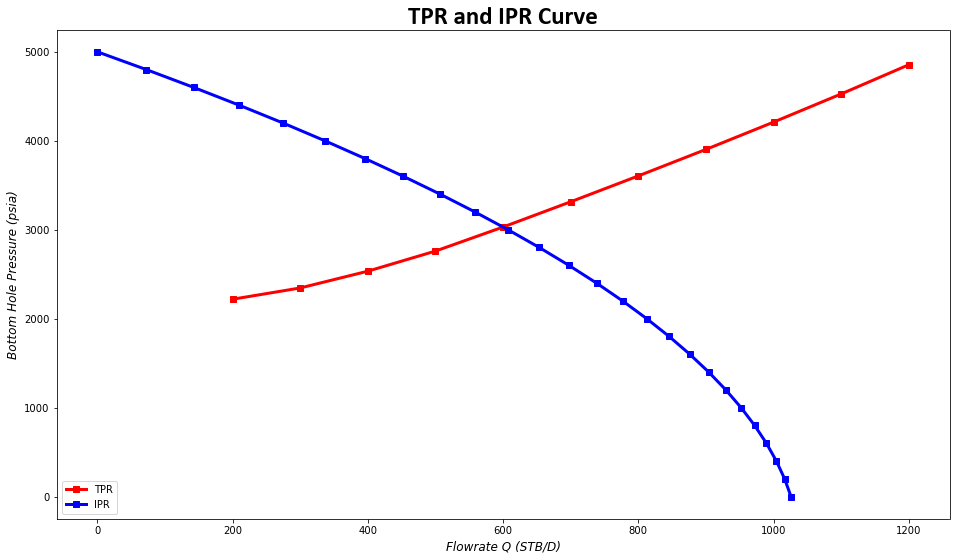

In [17]:
plt.figure(figsize=(16,9))

plt.plot(Qo_list, bottomhole_press_list, 'rs-', lw=3, label = 'TPR') #plotting the TPR and IPR on one chart
plt.plot(x_Q, y_P, 'bs-', lw=3, label = 'IPR')
plt.title("TPR and IPR Curve", size=25, weight='bold', fontfamily='calibri')
plt.xlabel('Flowrate Q (STB/D)', fontsize= 12, style='italic')
plt.ylabel('Bottom Hole Pressure (psia)', fontsize=12, style='italic')

plt.legend() #adding the legend

plt.show()